# Live coding

In [1]:
import tensorflow as tf
from tensorflow.keras import applications, layers, losses, optimizers, activations, metrics, Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

## Test configuration

In [2]:
model = Sequential()
model.add(layers.Input(shape=(28,28,1)))
model.add(layers.Conv2D(3,kernel_size=(3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation=layers.Softmax()))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 3)         30        
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4058      
Total params: 4,088
Trainable params: 4,088
Non-trainable params: 0
_________________________________________________________________


2021-10-20 17:12:37.443176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 17:12:38.041357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10486 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


In [3]:
out = model(np.random.randn(1,28,28,1))

2021-10-20 17:12:38.654628: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


In [4]:
out.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [5]:
out.numpy()

array([[0.38047758, 0.6195224 ]], dtype=float32)

# Dataset - Citrus Leaves

In [6]:
ds_train, ds_val, ds_test = tfds.load("citrus_leaves", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])
num_classes = 5

## Basic statistics

In [7]:
from collections import Counter

In [8]:
counter = Counter(sample["label"] for sample in ds_train.as_numpy_iterator())

2021-10-20 17:12:40.107376: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
sorted(counter.items())

[(0, 137), (1, 130), (2, 160), (3, 48)]

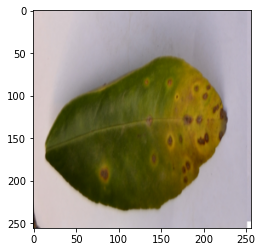

In [10]:
plt.imshow(next(ds_train.as_numpy_iterator())["image"])

In [11]:
next(ds_train.as_numpy_iterator())["image"].dtype

dtype('uint8')

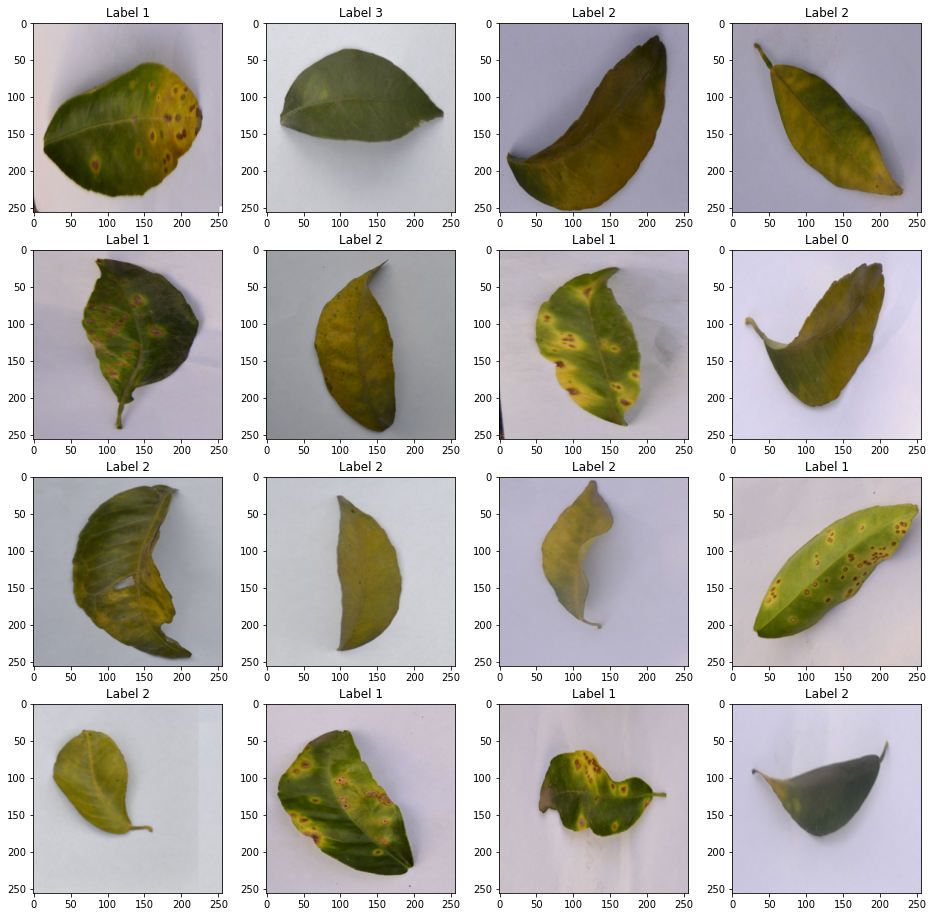

In [12]:
fig = plt.figure(figsize=(16,16))

for i, img in enumerate(ds_train.take(16).as_numpy_iterator()):
    sub = fig.add_subplot(4,4, i+1)
    sub.title.set_text("Label " + str(img["label"]))
    sub.imshow(img["image"])

# Prepare data

In [13]:
def prepare(img):
    X = img["image"]
    y = img["label"]
    X = tf.image.convert_image_dtype(X, dtype=tf.float32)
    return X, y

In [14]:
first_X, first_y = next(ds_train.map(prepare).take(1).as_numpy_iterator())

In [15]:
first_X

array([[[0.85098046, 0.79215693, 0.7960785 ],
        [0.854902  , 0.79215693, 0.8000001 ],
        [0.86274517, 0.8000001 , 0.80392164],
        ...,
        [0.76470596, 0.7294118 , 0.7960785 ],
        [0.75294125, 0.7294118 , 0.78823537],
        [0.75294125, 0.7254902 , 0.78823537]],

       [[0.854902  , 0.7960785 , 0.7960785 ],
        [0.8588236 , 0.8000001 , 0.8000001 ],
        [0.86274517, 0.8000001 , 0.80392164],
        ...,
        [0.7686275 , 0.73333335, 0.8000001 ],
        [0.75294125, 0.7254902 , 0.7843138 ],
        [0.75294125, 0.7254902 , 0.78823537]],

       [[0.854902  , 0.8000001 , 0.8000001 ],
        [0.8588236 , 0.8000001 , 0.80392164],
        [0.86274517, 0.8000001 , 0.80392164],
        ...,
        [0.76470596, 0.7254902 , 0.79215693],
        [0.7607844 , 0.7294118 , 0.7960785 ],
        [0.7607844 , 0.73333335, 0.79215693]],

       ...,

       [[0.29803923, 0.20000002, 0.09803922],
        [0.34117648, 0.2392157 , 0.1254902 ],
        [0.35686275, 0

In [16]:
first_X.shape

(256, 256, 3)

In [17]:
len(ds_train), len(ds_val), len(ds_test)

(475, 60, 59)

# Our first attempt - A simple CNN

In [18]:
model = Sequential()
model.add(layers.Input(shape=(256,256,3)))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation="softmax"))

In [19]:
model.compile(optimizer=optimizers.RMSprop(3e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 3)       84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 3)       84        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 3)       84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 3)        

## Fit the network

In [20]:
model_checkpoint = ModelCheckpoint("best-simple-3.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/simple-3")

2021-10-20 17:12:43.900863: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:12:43.900896: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:12:43.900957: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-10-20 17:12:43.901764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/targets/x86_64-linux/lib
2021-10-20 17:12:44.587623: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:12:44.587798: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [21]:
train = ds_train.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(475).batch(32)
val   = ds_val.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(60).batch(32)

In [22]:
history = model.fit(train, validation_data=val, epochs=60, callbacks=[model_checkpoint, early_stopping, tensorboard])

Epoch 1/60
 1/15 [=>............................] - ETA: 17s - loss: 1.6088 - accuracy: 0.1562

2021-10-20 17:12:46.068272: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:12:46.068311: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 5/15 [=========>....................] - ETA: 1s - loss: 1.5701 - accuracy: 0.2625

2021-10-20 17:12:46.455527: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:12:46.455983: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:12:46.495338: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 297 callback api events and 294 activity events. 
2021-10-20 17:12:46.501640: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:12:46.511392: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/simple-3/train/plugins/profile/2021_10_20_17_12_46

2021-10-20 17:12:46.515977: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/simple-3/train/plugins/profile/2021_10_20_17_12_46/XXXX.trace.json.gz
2021-10-20 17:12:46.531714: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creat

15/15 [==============================] - 3s 103ms/step - loss: 1.4793 - accuracy: 0.3011 - val_loss: 1.2794 - val_accuracy: 0.4000
Epoch 2/60
15/15 [==============================] - 0s 26ms/step - loss: 1.3728 - accuracy: 0.3116 - val_loss: 1.2526 - val_accuracy: 0.4000
Epoch 3/60
15/15 [==============================] - 0s 27ms/step - loss: 1.3434 - accuracy: 0.3263 - val_loss: 1.1998 - val_accuracy: 0.3667
Epoch 4/60
15/15 [==============================] - 0s 28ms/step - loss: 1.3462 - accuracy: 0.3200 - val_loss: 1.2340 - val_accuracy: 0.4000
Epoch 5/60
15/15 [==============================] - 0s 28ms/step - loss: 1.3556 - accuracy: 0.3179 - val_loss: 1.2013 - val_accuracy: 0.4000
Epoch 6/60
15/15 [==============================] - 0s 28ms/step - loss: 1.3283 - accuracy: 0.3474 - val_loss: 1.1916 - val_accuracy: 0.4333
Epoch 7/60
15/15 [==============================] - 0s 27ms/step - loss: 1.3096 - accuracy: 0.3811 - val_loss: 1.1723 - val_accuracy: 0.4333
Epoch 8/60
15/15 [=====

## Plot the loss curvs

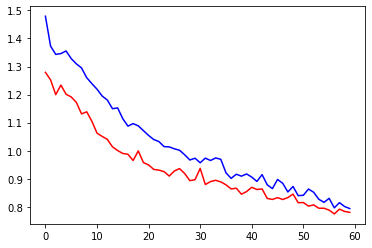

In [23]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

## Evaluate

In [24]:
y_pred_prob = model.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

In [25]:
result_simple = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.85      0.56        13
           1       0.93      0.78      0.85        18
           2       0.58      0.35      0.44        20
           3       0.83      0.62      0.71         8

    accuracy                           0.63        59
   macro avg       0.69      0.65      0.64        59
weighted avg       0.69      0.63      0.63        59



# Augmentation

In [26]:
def show_example(n, image, layer):
    """
    n: number of examples to produce
    image: the image to augment
    layer: the augmentation layer
    """
    for i in range(n):
        im = layer(image)
        plt.imshow(im)
        plt.show()

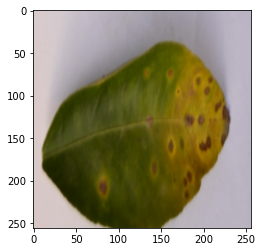

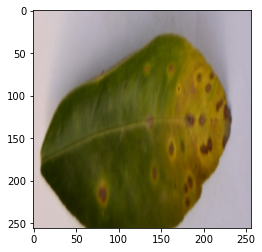

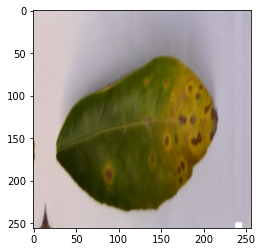

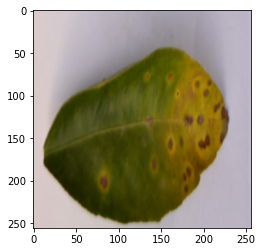

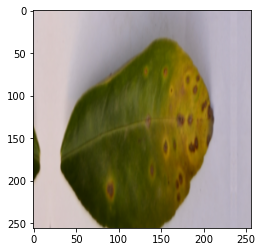

In [27]:
show_example(5, first_X, layers.RandomZoom(0.3, 0.2))

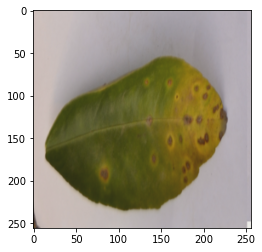

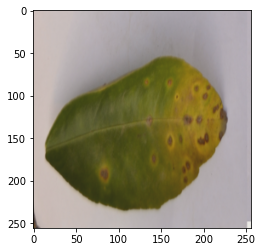

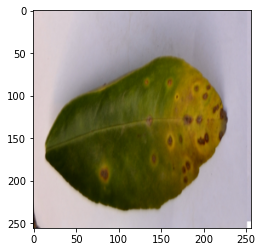

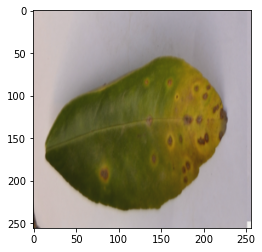

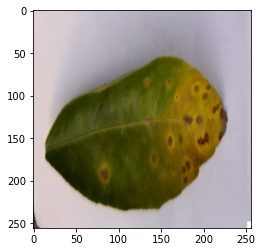

In [28]:
show_example(5, first_X, layers.RandomContrast(0.2))

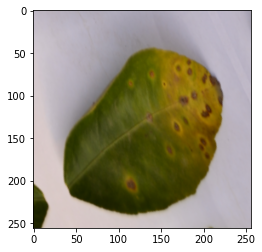

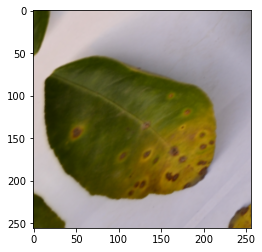

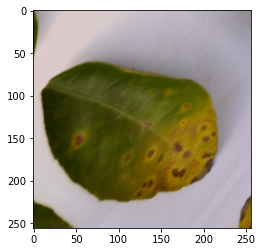

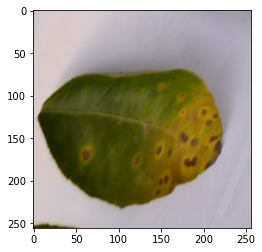

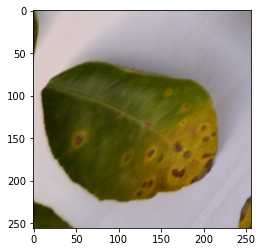

In [29]:
show_example(5, first_X, layers.RandomRotation(0.2))

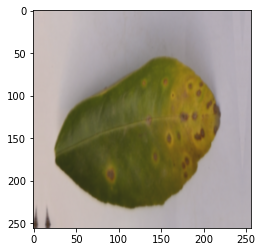

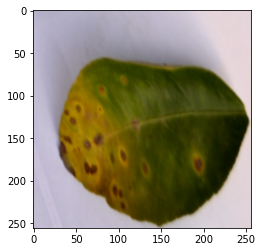

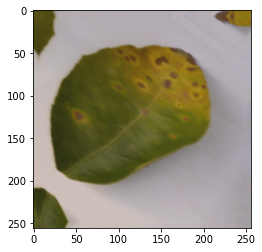

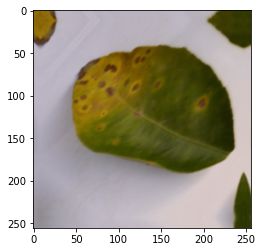

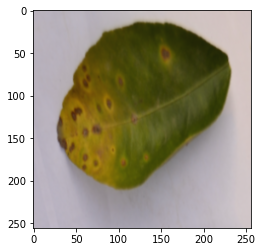

In [30]:
augmentation = Sequential()
augmentation.add(layers.RandomRotation(0.2))
augmentation.add(layers.RandomZoom(0.2, 0.1))
augmentation.add(layers.RandomFlip())
augmentation.add(layers.RandomContrast(0.2))

show_example(5, first_X, augmentation)

# Our second attempt - augmenting the simple net

In [31]:
tf.keras.backend.clear_session() # Clean up existing graphs

augmentation = Sequential()
augmentation.add(layers.RandomRotation(0.2))
augmentation.add(layers.RandomZoom(0.2, 0.1))
augmentation.add(layers.RandomFlip())
augmentation.add(layers.RandomContrast(0.2))

model_aug = Sequential()
model_aug.add(layers.Input(shape=(256,256,3)))
model_aug.add(augmentation)
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.MaxPooling2D(2,2))
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.MaxPooling2D(2,2))
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.Conv2D(3, kernel_size=(3,3), activation="relu"))
model_aug.add(layers.MaxPooling2D(2,2))
model_aug.add(layers.Flatten())
model_aug.add(layers.Dropout(0.5))
model_aug.add(layers.Dense(100, activation="relu"))
model_aug.add(layers.Dropout(0.5))
model_aug.add(layers.Dense(5, activation="softmax"))

model_checkpoint = ModelCheckpoint("best-simple-aug-1.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/simple-aug-1")

model_aug.compile(optimizer=optimizers.RMSprop(3e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_aug.fit(train.repeat(2), validation_data=val, epochs=60, callbacks=[model_checkpoint, early_stopping, tensorboard])

2021-10-20 17:13:22.233020: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:13:22.233053: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:13:22.823323: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:13:22.823534: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/60
 1/30 [>.............................] - ETA: 35s - loss: 6.0338 - accuracy: 0.1875

2021-10-20 17:13:24.154820: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:13:24.154851: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/30 [==>...........................] - ETA: 7s - loss: 3.9713 - accuracy: 0.3125

2021-10-20 17:13:24.533718: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:13:24.534220: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:13:24.567565: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 432 callback api events and 429 activity events. 
2021-10-20 17:13:24.577825: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:13:24.591227: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/simple-aug-1/train/plugins/profile/2021_10_20_17_13_24

2021-10-20 17:13:24.598180: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/simple-aug-1/train/plugins/profile/2021_10_20_17_13_24/XXXX.trace.json.gz
2021-10-20 17:13:24.620396: I tensorflow/core/profiler/rpc/client/save_profile.cc:13

30/30 [==============================] - 3s 57ms/step - loss: 1.9880 - accuracy: 0.2842 - val_loss: 1.2875 - val_accuracy: 0.3500
Epoch 2/60
30/30 [==============================] - 1s 28ms/step - loss: 1.4527 - accuracy: 0.2884 - val_loss: 1.3040 - val_accuracy: 0.3500
Epoch 3/60
30/30 [==============================] - 1s 29ms/step - loss: 1.4181 - accuracy: 0.3105 - val_loss: 1.2940 - val_accuracy: 0.3500
Epoch 4/60
30/30 [==============================] - 1s 29ms/step - loss: 1.3895 - accuracy: 0.2968 - val_loss: 1.2741 - val_accuracy: 0.3833
Epoch 5/60
30/30 [==============================] - 1s 36ms/step - loss: 1.3686 - accuracy: 0.3284 - val_loss: 1.2737 - val_accuracy: 0.4167
Epoch 6/60
30/30 [==============================] - 1s 31ms/step - loss: 1.3420 - accuracy: 0.3695 - val_loss: 1.2335 - val_accuracy: 0.4000
Epoch 7/60
30/30 [==============================] - 1s 37ms/step - loss: 1.3194 - accuracy: 0.3874 - val_loss: 1.2057 - val_accuracy: 0.4500
Epoch 8/60
30/30 [======

## Plot loss curves

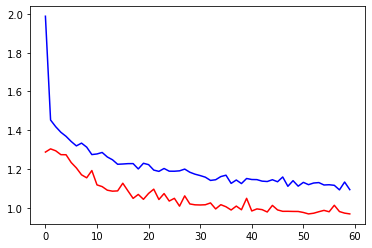

In [32]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

## Evaluate

In [33]:
y_pred_prob = model.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

result_simple_aug = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.42      0.85      0.56        13
           1       0.93      0.78      0.85        18
           2       0.58      0.35      0.44        20
           3       0.83      0.62      0.71         8

    accuracy                           0.63        59
   macro avg       0.69      0.65      0.64        59
weighted avg       0.69      0.63      0.63        59



,0,1,2,3
0,11,0,2,0
1,1,14,3,0
2,11,1,7,1
3,3,0,0,5


# Transfer learning

In [34]:
transfer_model = applications.Xception(include_top=False, input_shape=(256,256,3))
transfer_model.trainable = False  # Important to freeze the weights, missed this during the lecture

In [35]:
# Functional style
inputs = layers.Input(shape=(256,256,3))
x = transfer_model(inputs, training=False)  # set training to True when fine-tuning the transferred model, training = True enables regaulization layers such as Dropout
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_transfer = Model(inputs=[inputs], outputs=[outputs])

model_transfer.compile(optimizer=optimizers.RMSprop(3e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transfer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


## Fit the network

In [36]:
model_checkpoint = ModelCheckpoint("best-transfer-1.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/transfer-1")

history = model_transfer.fit(train, validation_data=val, epochs=60, callbacks=[model_checkpoint, early_stopping, tensorboard])

2021-10-20 17:14:25.664370: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:14:25.664402: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:14:26.240578: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:14:26.240773: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/mnt/fastdisk/BioNLP/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/60
 1/15 [=>............................] - ETA: 37s - loss: 1.5308 - accuracy: 0.3125

2021-10-20 17:14:29.090156: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:14:29.090184: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/15 [=====>........................] - ETA: 4s - loss: 1.5388 - accuracy: 0.2500

2021-10-20 17:14:29.555754: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:14:29.556772: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:14:29.594675: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 298 callback api events and 295 activity events. 
2021-10-20 17:14:29.602076: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:14:29.611202: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/transfer-1/train/plugins/profile/2021_10_20_17_14_29

2021-10-20 17:14:29.615787: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/transfer-1/train/plugins/profile/2021_10_20_17_14_29/XXXX.trace.json.gz
2021-10-20 17:14:29.643207: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] C

15/15 [==============================] - 6s 234ms/step - loss: 1.3484 - accuracy: 0.3516 - val_loss: 1.0927 - val_accuracy: 0.6167
Epoch 2/60
15/15 [==============================] - 1s 99ms/step - loss: 1.1994 - accuracy: 0.4821 - val_loss: 1.0024 - val_accuracy: 0.6500
Epoch 3/60
15/15 [==============================] - 1s 86ms/step - loss: 1.1010 - accuracy: 0.5516 - val_loss: 0.9272 - val_accuracy: 0.7000
Epoch 4/60
15/15 [==============================] - 1s 89ms/step - loss: 1.0005 - accuracy: 0.6189 - val_loss: 0.8687 - val_accuracy: 0.7333
Epoch 5/60
15/15 [==============================] - 1s 88ms/step - loss: 0.9544 - accuracy: 0.6253 - val_loss: 0.8202 - val_accuracy: 0.7167
Epoch 6/60
15/15 [==============================] - 1s 96ms/step - loss: 0.9069 - accuracy: 0.6589 - val_loss: 0.7739 - val_accuracy: 0.7667
Epoch 7/60
15/15 [==============================] - 1s 95ms/step - loss: 0.8398 - accuracy: 0.6842 - val_loss: 0.7482 - val_accuracy: 0.7333
Epoch 8/60
15/15 [=====

## Plot loss curves

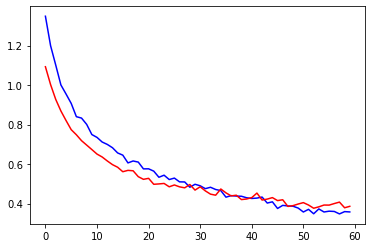

In [37]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

## Evaluate

In [38]:
y_pred_prob = model_transfer.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

result_transfer = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.60      0.92      0.73        13
           1       1.00      0.94      0.97        18
           2       0.75      0.60      0.67        20
           3       0.83      0.62      0.71         8

    accuracy                           0.78        59
   macro avg       0.80      0.77      0.77        59
weighted avg       0.80      0.78      0.78        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,7,0,12,1
3,1,0,2,5


# Transfer learning with fine-tuning

In [39]:
transfer_model_fine = applications.Xception(include_top=False, input_shape=(256,256,3))
transfer_model_fine.trainable = True  # Is true by default

# Functional style
inputs = layers.Input(shape=(256,256,3))
x = transfer_model_fine(inputs) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_transfer_fine = Model(inputs=[inputs], outputs=[outputs])
model_transfer_fine.compile(optimizer=optimizers.RMSprop(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transfer_fine.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [40]:
model_checkpoint = ModelCheckpoint("best-transfer-fine-1.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/transfer-fine-1")

history = model_transfer_fine.fit(train, validation_data=val, epochs=20, callbacks=[model_checkpoint, early_stopping, tensorboard])

2021-10-20 17:16:07.112342: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:16:07.112392: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:16:07.706779: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:16:07.707037: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/mnt/fastdisk/BioNLP/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
 1/15 [=>............................] - ETA: 1:45 - loss: 1.5748 - accuracy: 0.1562

2021-10-20 17:16:15.495545: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:16:15.495580: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/15 [===>..........................] - ETA: 15s - loss: 1.4907 - accuracy: 0.2031 

2021-10-20 17:16:17.133866: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:16:17.139118: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:16:17.213456: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2403 callback api events and 2400 activity events. 
2021-10-20 17:16:17.271662: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:16:17.350398: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/transfer-fine-1/train/plugins/profile/2021_10_20_17_16_17

2021-10-20 17:16:17.381203: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/transfer-fine-1/train/plugins/profile/2021_10_20_17_16_17/XXXX.trace.json.gz
2021-10-20 17:16:17.481073: I tensorflow/core/profiler/rpc/client/save_profi

15/15 [==============================] - 16s 634ms/step - loss: 0.9441 - accuracy: 0.6442 - val_loss: 0.9284 - val_accuracy: 0.5667
Epoch 2/20
15/15 [==============================] - 6s 394ms/step - loss: 0.2744 - accuracy: 0.9621 - val_loss: 0.6329 - val_accuracy: 0.6333
Epoch 3/20
15/15 [==============================] - 6s 407ms/step - loss: 0.1124 - accuracy: 0.9874 - val_loss: 0.3686 - val_accuracy: 0.8667
Epoch 4/20
15/15 [==============================] - 6s 403ms/step - loss: 0.0453 - accuracy: 0.9937 - val_loss: 0.2796 - val_accuracy: 0.9000
Epoch 5/20
15/15 [==============================] - 6s 401ms/step - loss: 0.0333 - accuracy: 0.9937 - val_loss: 0.2316 - val_accuracy: 0.9167
Epoch 6/20
15/15 [==============================] - 6s 390ms/step - loss: 0.0179 - accuracy: 0.9979 - val_loss: 0.2070 - val_accuracy: 0.9000
Epoch 7/20
15/15 [==============================] - 6s 417ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1844 - val_accuracy: 0.9333
Epoch 8/20
15/15

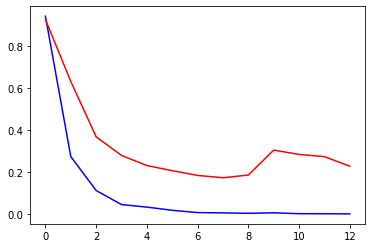

In [41]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

In [42]:
y_pred_prob = model_transfer_fine.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

result_transfer_finetuning = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       1.00      0.94      0.97        18
           2       0.64      0.90      0.75        20
           3       1.00      0.25      0.40         8

    accuracy                           0.80        59
   macro avg       0.87      0.72      0.73        59
weighted avg       0.84      0.80      0.78        59



,0,1,2,3
0,10,0,3,0
1,0,17,1,0
2,2,0,18,0
3,0,0,6,2


# Transfer learning - Augmentation

In [43]:
augmentation = Sequential()
augmentation.add(layers.RandomRotation(0.2))
augmentation.add(layers.RandomZoom(0.2, 0.1))
augmentation.add(layers.RandomFlip())
augmentation.add(layers.RandomContrast(0.2))

inputs = layers.Input(shape=(256,256,3))
x = augmentation(inputs)
x = transfer_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_transfer = Model(inputs=[inputs], outputs=[outputs])

model_transfer.compile(optimizer=optimizers.RMSprop(3e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transfer.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
___________________________________________

## Fit the network

In [44]:
model_checkpoint = ModelCheckpoint("best-transfer-aug-1.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/transfer-aug-1")

history = model_transfer.fit(train.repeat(2), validation_data=val, epochs=60, callbacks=[model_checkpoint, early_stopping, tensorboard])

2021-10-20 17:17:42.892357: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:17:42.892406: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:17:43.453077: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:17:43.453262: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/mnt/fastdisk/BioNLP/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/60
 1/30 [>.............................] - ETA: 1:09 - loss: 1.4483 - accuracy: 0.3125

2021-10-20 17:17:46.040510: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:17:46.040537: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 3/30 [==>...........................] - ETA: 13s - loss: 1.3693 - accuracy: 0.3229

2021-10-20 17:17:46.739107: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:17:46.740138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:17:46.778057: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 433 callback api events and 430 activity events. 
2021-10-20 17:17:46.790308: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:17:46.804308: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/transfer-aug-1/train/plugins/profile/2021_10_20_17_17_46

2021-10-20 17:17:46.811284: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/transfer-aug-1/train/plugins/profile/2021_10_20_17_17_46/XXXX.trace.json.gz
2021-10-20 17:17:46.847537: I tensorflow/core/profiler/rpc/client/save_profile.c

30/30 [==============================] - 6s 133ms/step - loss: 1.2165 - accuracy: 0.4442 - val_loss: 0.9994 - val_accuracy: 0.6667
Epoch 2/60
30/30 [==============================] - 2s 83ms/step - loss: 1.0642 - accuracy: 0.5537 - val_loss: 0.8836 - val_accuracy: 0.7000
Epoch 3/60
30/30 [==============================] - 3s 86ms/step - loss: 0.9901 - accuracy: 0.5989 - val_loss: 0.8111 - val_accuracy: 0.7833
Epoch 4/60
30/30 [==============================] - 2s 81ms/step - loss: 0.9101 - accuracy: 0.6432 - val_loss: 0.7587 - val_accuracy: 0.7667
Epoch 5/60
30/30 [==============================] - 2s 82ms/step - loss: 0.8563 - accuracy: 0.6568 - val_loss: 0.7329 - val_accuracy: 0.7667
Epoch 6/60
30/30 [==============================] - 2s 82ms/step - loss: 0.8029 - accuracy: 0.7000 - val_loss: 0.6776 - val_accuracy: 0.8000
Epoch 7/60
30/30 [==============================] - 2s 83ms/step - loss: 0.7787 - accuracy: 0.6853 - val_loss: 0.6609 - val_accuracy: 0.7833
Epoch 8/60
30/30 [=====

## Plot the loss curves

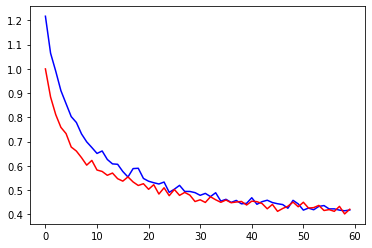

In [45]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

## Evaluate

In [46]:
y_pred_prob = model_transfer.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

result_transfer_aug = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.57      0.92      0.71        13
           1       1.00      0.94      0.97        18
           2       0.79      0.55      0.65        20
           3       0.86      0.75      0.80         8

    accuracy                           0.78        59
   macro avg       0.80      0.79      0.78        59
weighted avg       0.81      0.78      0.78        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,8,0,11,1
3,1,0,1,6


# Transfer learning with fine-tuning - augmentation

In [47]:
tf.keras.backend.clear_session() # Clean up existing graphs

transfer_model_fine = applications.Xception(include_top=False, input_shape=(256,256,3))
transfer_model_fine.trainable = True  # Is true by default

augmentation = Sequential()
augmentation.add(layers.RandomRotation(0.2))
augmentation.add(layers.RandomZoom(0.2, 0.1))
augmentation.add(layers.RandomFlip())
augmentation.add(layers.RandomContrast(0.2))

inputs = layers.Input(shape=(256,256,3))
x = augmentation(inputs)
x = transfer_model_fine(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_transfer_fine_aug = Model(inputs=[inputs], outputs=[outputs])

model_transfer_fine_aug.compile(optimizer=optimizers.RMSprop(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_transfer_fine_aug.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
____________________________________________

In [48]:
model_checkpoint = ModelCheckpoint("best-transfer-fine-aug-1.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
tensorboard = TensorBoard("../tensorboard/transfer-aug-1")

history = model_transfer_fine_aug.fit(train.repeat(2), validation_data=val, epochs=20, callbacks=[model_checkpoint, early_stopping, tensorboard])

2021-10-20 17:20:31.820958: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:20:31.820995: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 17:20:32.395650: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:20:32.395822: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/mnt/fastdisk/BioNLP/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
 1/30 [>.............................] - ETA: 3:31 - loss: 1.4055 - accuracy: 0.2500

2021-10-20 17:20:39.984317: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 17:20:39.984367: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/30 [=>............................] - ETA: 25s - loss: 1.3481 - accuracy: 0.3594 

2021-10-20 17:20:41.359495: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 17:20:41.364648: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 17:20:41.441891: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2538 callback api events and 2535 activity events. 
2021-10-20 17:20:41.504922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 17:20:41.602650: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../tensorboard/transfer-aug-1/train/plugins/profile/2021_10_20_17_20_41

2021-10-20 17:20:41.635410: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../tensorboard/transfer-aug-1/train/plugins/profile/2021_10_20_17_20_41/XXXX.trace.json.gz
2021-10-20 17:20:41.739004: I tensorflow/core/profiler/rpc/client/save_profile

30/30 [==============================] - 21s 487ms/step - loss: 0.7366 - accuracy: 0.7295 - val_loss: 0.4774 - val_accuracy: 0.7667
Epoch 2/20
30/30 [==============================] - 12s 406ms/step - loss: 0.2489 - accuracy: 0.9221 - val_loss: 0.4143 - val_accuracy: 0.8167
Epoch 3/20
30/30 [==============================] - 12s 403ms/step - loss: 0.1491 - accuracy: 0.9547 - val_loss: 0.3113 - val_accuracy: 0.9333
Epoch 4/20
30/30 [==============================] - 12s 404ms/step - loss: 0.1099 - accuracy: 0.9579 - val_loss: 0.3102 - val_accuracy: 0.9000
Epoch 5/20
30/30 [==============================] - 12s 407ms/step - loss: 0.0902 - accuracy: 0.9684 - val_loss: 0.2160 - val_accuracy: 0.9333
Epoch 6/20
30/30 [==============================] - 12s 410ms/step - loss: 0.0650 - accuracy: 0.9821 - val_loss: 0.2506 - val_accuracy: 0.9333
Epoch 7/20
30/30 [==============================] - 12s 403ms/step - loss: 0.0636 - accuracy: 0.9737 - val_loss: 0.2768 - val_accuracy: 0.9500
Epoch 8/20

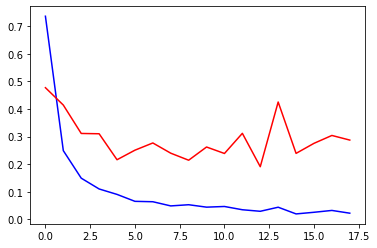

In [49]:
plt.plot(history.history["loss"], "b")
plt.plot(history.history["val_loss"], "r")

In [50]:
y_pred_prob = model_transfer_fine_aug.predict(ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE).batch(128))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array([y for X,y in ds_test.map(prepare, num_parallel_calls=tf.data.AUTOTUNE)])

result_transfer_finetuned_aug = classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred)

# Print out
print(classification_report(y_true, y_pred))
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       1.00      0.94      0.97        18
           2       0.89      0.85      0.87        20
           3       1.00      1.00      1.00         8

    accuracy                           0.92        59
   macro avg       0.92      0.93      0.93        59
weighted avg       0.92      0.92      0.92        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,3,0,17,0
3,0,0,0,8


# Summary

## Simple CNN

In [51]:
print(result_simple[0])
pd.DataFrame(result_simple[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.42      0.85      0.56        13
           1       0.93      0.78      0.85        18
           2       0.58      0.35      0.44        20
           3       0.83      0.62      0.71         8

    accuracy                           0.63        59
   macro avg       0.69      0.65      0.64        59
weighted avg       0.69      0.63      0.63        59



,0,1,2,3
0,11,0,2,0
1,1,14,3,0
2,11,1,7,1
3,3,0,0,5


## Simple CNN - augmented input

In [52]:
print(result_simple_aug[0])
pd.DataFrame(result_simple_aug[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.42      0.85      0.56        13
           1       0.93      0.78      0.85        18
           2       0.58      0.35      0.44        20
           3       0.83      0.62      0.71         8

    accuracy                           0.63        59
   macro avg       0.69      0.65      0.64        59
weighted avg       0.69      0.63      0.63        59



,0,1,2,3
0,11,0,2,0
1,1,14,3,0
2,11,1,7,1
3,3,0,0,5


## Transfer learning with Xception

In [53]:
print(result_transfer[0])
pd.DataFrame(result_transfer[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.60      0.92      0.73        13
           1       1.00      0.94      0.97        18
           2       0.75      0.60      0.67        20
           3       0.83      0.62      0.71         8

    accuracy                           0.78        59
   macro avg       0.80      0.77      0.77        59
weighted avg       0.80      0.78      0.78        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,7,0,12,1
3,1,0,2,5


In [54]:
## Transfer learning with Xception - augmented input

print(result_transfer_aug[0])
pd.DataFrame(result_transfer_aug[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.57      0.92      0.71        13
           1       1.00      0.94      0.97        18
           2       0.79      0.55      0.65        20
           3       0.86      0.75      0.80         8

    accuracy                           0.78        59
   macro avg       0.80      0.79      0.78        59
weighted avg       0.81      0.78      0.78        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,8,0,11,1
3,1,0,1,6


## Transfer learning with finetuned Xception

In [55]:
print(result_transfer_finetuning[0])
pd.DataFrame(result_transfer_finetuning[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       1.00      0.94      0.97        18
           2       0.64      0.90      0.75        20
           3       1.00      0.25      0.40         8

    accuracy                           0.80        59
   macro avg       0.87      0.72      0.73        59
weighted avg       0.84      0.80      0.78        59



,0,1,2,3
0,10,0,3,0
1,0,17,1,0
2,2,0,18,0
3,0,0,6,2


## Transfer learning with finetuned Xception - augmented input

In [56]:
print(result_transfer_finetuned_aug[0])
pd.DataFrame(result_transfer_finetuned_aug[1], columns=list(range(4)))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       1.00      0.94      0.97        18
           2       0.89      0.85      0.87        20
           3       1.00      1.00      1.00         8

    accuracy                           0.92        59
   macro avg       0.92      0.93      0.93        59
weighted avg       0.92      0.92      0.92        59



,0,1,2,3
0,12,0,1,0
1,0,17,1,0
2,3,0,17,0
3,0,0,0,8
